# MIMIC ML/DL

AI IN HEALTHCARE-WB 54315 Tutorial

## Predicting ICU Transfer from Admission Data

### Practical Purpose

Given information available at hospital admission time, predict whether the patient will require ICU care during that hospital stay.

### Learning Goal

Get familiar with the machine learning and deep learning technologies and know how to apply them to analyze EHR data and derive insights

### Dataset

[MIMIC-IV](https://physionet.org/content/mimiciv/3.1/) (requires credentials to access)

### ML/DL Models

LogisticRegression, MLP

## Step 1 - Data Extraction and Labeling

### Objective

Import the relevant data → Prepare and label for training

### Result

Collection of admission events, labeled by whether or not an ICU stay followed:
- Positive (1): admissions including at least one ICU stay
- Negative (0): admission never transfers to ICU

In [2]:
MIMIC_IV = '../mimic-iv'
RANDOM_SEED = 42

import pandas as pd
admissions = pd.read_csv(f"{MIMIC_IV}/admissions.csv.gz")
patients   = pd.read_csv(f"{MIMIC_IV}/patients.csv.gz")
icustays   = pd.read_csv(f"{MIMIC_IV}/icustays.csv.gz")

# build cohort and label
#   one row per hospital admission y=1 if admission ever appears in ICU stay, y=0 otherwise

# start by labeling every admission in ICU as 1
icu_labeled = icustays[["hadm_id"]].drop_duplicates().assign(y=1)
icu_labeled.head()

# merge labeled ICU into admissions and fill missing values with 0
cohort = (
    admissions.merge(icu_labeled, on="hadm_id", how="left")
              .assign(y=lambda df: df["y"].fillna(0).astype(int))
)

### Evaluate Labels

In [3]:
# so now any admission that appears in the ICU stay is labeled as 1, otherwise it is a 0
# let's take a look at the distribution
cohort["y"].value_counts()


y
0    460786
1     85242
Name: count, dtype: int64

## Step 2 - Feature Engineering

### Add Age and Gender from Patients Table

In [4]:
# add some basic demographic information to the cohort from the patients table
# most of the other demographic info was already in the admissions table
patients.describe()
cohort = cohort.merge(
    patients[["subject_id", "anchor_age", "gender"]],
    on="subject_id",
    how="left"
)
cohort.info()

# look at the age distribution - 18 is already the minimum age
cohort["anchor_age"].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            546028 non-null  int64 
 1   hadm_id               546028 non-null  int64 
 2   admittime             546028 non-null  object
 3   dischtime             546028 non-null  object
 4   deathtime             11790 non-null   object
 5   admission_type        546028 non-null  object
 6   admit_provider_id     546024 non-null  object
 7   admission_location    546027 non-null  object
 8   discharge_location    396210 non-null  object
 9   insurance             536673 non-null  object
 10  language              545253 non-null  object
 11  marital_status        532409 non-null  object
 12  race                  546028 non-null  object
 13  edregtime             379240 non-null  object
 14  edouttime             379240 non-null  object
 15  hospital_expire_f

count    546028.000000
mean         56.890777
std          18.969772
min          18.000000
25%          43.000000
50%          58.000000
75%          71.000000
max          91.000000
Name: anchor_age, dtype: float64

### Keep First Admission for a Patient

In [6]:
# to simplify and avoid multiple correlated samples for the same patient keep
# only the first admission per patient
cohort = (
    cohort.sort_values(["subject_id", "admittime"])
)

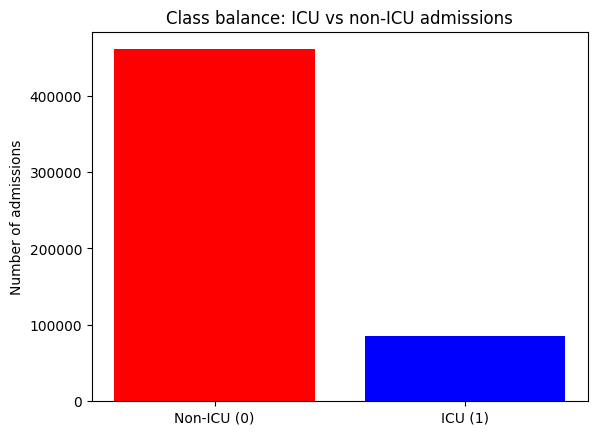

y
0    0.843887
1    0.156113
Name: proportion, dtype: float64

In [7]:
# Visualize the distribution of the labels
import matplotlib.pyplot as plt

class_counts = cohort["y"].value_counts().sort_index()
plt.figure()
plt.bar(["Non-ICU (0)", "ICU (1)"], class_counts.values, color=["#ff0000", "#0000ff"])
plt.title("Class balance: ICU vs non-ICU admissions")
plt.ylabel("Number of admissions")
plt.show()
cohort["y"].value_counts(normalize=True)


### Choose Features

Initially, keep the feature set deliberately small and interpretable:

**Numeric feature**:

- anchor_age (age)

**Categorical features**:

- gender
- admission_type (EMERGENCY, ELECTIVE, URGENT, etc.)
- admission_location (ED, transfer from other hospital, clinic, …)
- insurance (Medicare, Medicaid, Private, Self Pay, …)
- race (broad categories)
- language (English, Spanish, French, etc.)
- marital_status (Single, Married, Divorced, Widowed, etc.)

In [8]:
num_cols = ["anchor_age"]
cat_cols = [
    "gender",
    "admission_type",
    "admission_location",
    "insurance",
    "race",
    "language",
    "marital_status",
]
features = num_cols + cat_cols

data = cohort[["hadm_id", "y"] + features].copy()
data.head()


,hadm_id,y,anchor_age,gender,admission_type,admission_location,insurance,race,language,marital_status
0,22595853,0,52,F,URGENT,TRANSFER FROM HOSPITAL,Medicaid,WHITE,English,WIDOWED
1,22841357,0,52,F,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,English,WIDOWED
3,29079034,1,52,F,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,English,WIDOWED
2,25742920,0,52,F,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,English,WIDOWED
4,25022803,0,19,F,EU OBSERVATION,EMERGENCY ROOM,NaN,WHITE,English,SINGLE


### Handle Missing Features

- `insurance` -> "NONE"
- `language` -> "English" (assume not noting language means not noteworthy)
- `marital_status` -> "Unknown"
- `admission_location` -> "TRANSFER FROM HOSPITAL" (determined to be most likely for 1 row with missing value)

In [10]:
# call missing insurance "NONE"
data["insurance"] = data["insurance"].fillna("NONE")
# assuming missing language means English
data["language"] = data["language"].fillna("English")
data["language"].value_counts()

# call missing marital status and religion "Unknown"
data["marital_status"] = data["marital_status"].fillna("Unknown")
data["marital_status"].value_counts()

# there's a single row with a missing admission location. It's admission type
# is "URGENT, so assume it was a TRANSFER FROM HOSPITAL, since that is the 
# location most often associated with urgent admissions
data[data["admission_location"].isna()]
data[data["admission_type"] == "URGENT"]["admission_location"].value_counts()
data["admission_location"] = data["admission_location"].fillna("TRANSFER FROM HOSPITAL")



### One-hot Encode Categorical Features

And cast booleans to 1.0 or 0.0 to make them easier to work with later

In [11]:
X = pd.get_dummies(data[features], columns=cat_cols, dummy_na=False)

# cast age to float, since we will normalize after splitting
# cast one-hot encoded columns to float, since our MLP model expects that
X = X.astype("float64")
